# Выбор локации для нефтяной скважины
Нужно решить, где бурить новую скважину.
Классические шаги для выбора локации:
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов (данные уже собраны);
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль. Нужно проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:
* /datasets/geo_data_0.csv.
* /datasets/geo_data_1.csv. 
* /datasets/geo_data_2.csv. 
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только **линейная регрессия** (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## План работы
1. Загрузить и подготовить данные. 
2. Обучить и проверить модель для каждого региона:

    2.1. Разбить данные на обучающую и валидационную выборки в соотношении 3:1.

    2.2. Обучить модель и сделать предсказания на валидационной выборке.

    2.3. Сохранить предсказания и правильные ответы на валидационной выборке.

    2.4. Определить средний запас предсказанного сырья и RMSE модели.

    2.5. Анализ результатов.
3. Подготовка к расчёту прибыли:

    3.1. Все ключевые значения для расчётов сохранить в константах.
    
    3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.

4. Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:

    4.1. Выбрать скважины с максимальными значениями предсказаний.

    4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.

    4.3. Рассчитать прибыль для полученного объёма сырья.

5. Посчитать риски и прибыль для каждого региона:

    5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

    5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск отрицательной прибыли (убытков).

    5.3. Предложить регион для разработки скважин.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import percentileofscore


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## Шаг 1. Загрузка и подготовка данных
План загрузки и подготовки данных
* Прочитать файлы
* Вывести первые строки, информацию о таблицах, статистику по значениям 
* Проверить название столбцов, при необходимости привести к змеиному регистру
* Проверить наличие явных дубликатов, при необходимости обработать дубликаты
* Преобразовать типы данных, при необходимости
* Проверить наличие пропусков в данных, при необходимости обработать пропуски
* Проверить наличие выбросов, при необходимости обработать

In [3]:
#загрузка файлов
for i in range(3):
    globals()[f'df_{i}'] = pd.read_csv(f'f:/yandex-practicum/datasets/geo_data_{i}.csv')


In [4]:
[globals()[f'df_{i}'].info() for i in range(3)];# просмотр размера таблицы, типов данных, количества non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [5]:
# просмотр первых строк данных
[display(globals()[f'df_{i}'].head()) for i in range(3)] ;

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [6]:
[display(globals()[f'df_{i}'].describe()) for i in range(3)];


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


In [7]:
# Поиск явных дубликатов
[globals()[f'df_{i}'].duplicated().sum() for i in range(3)]

[0, 0, 0]

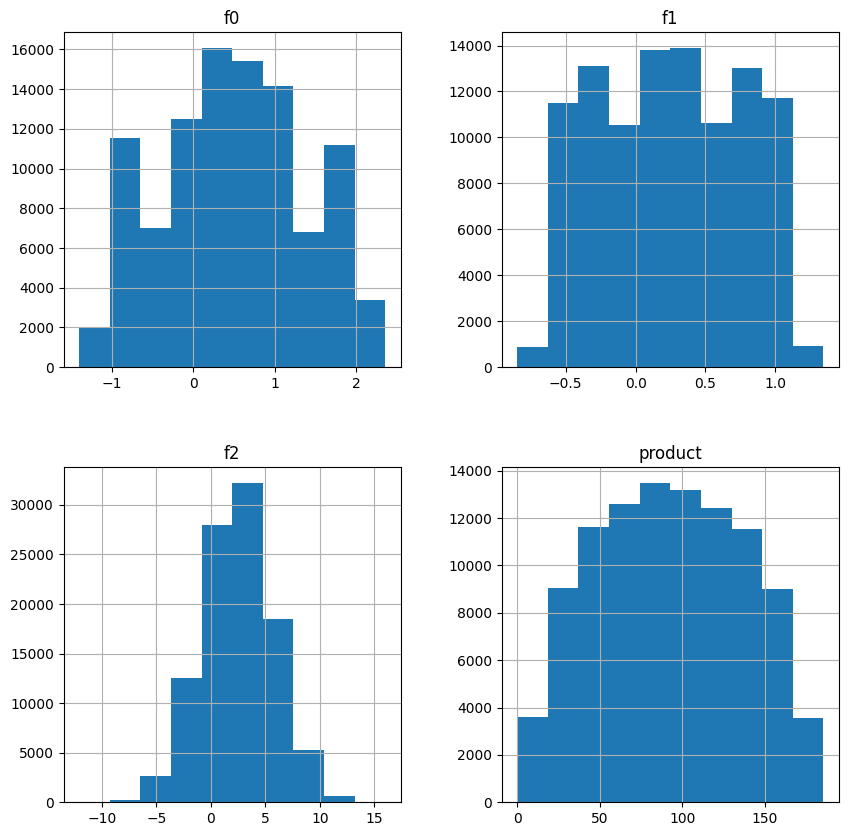

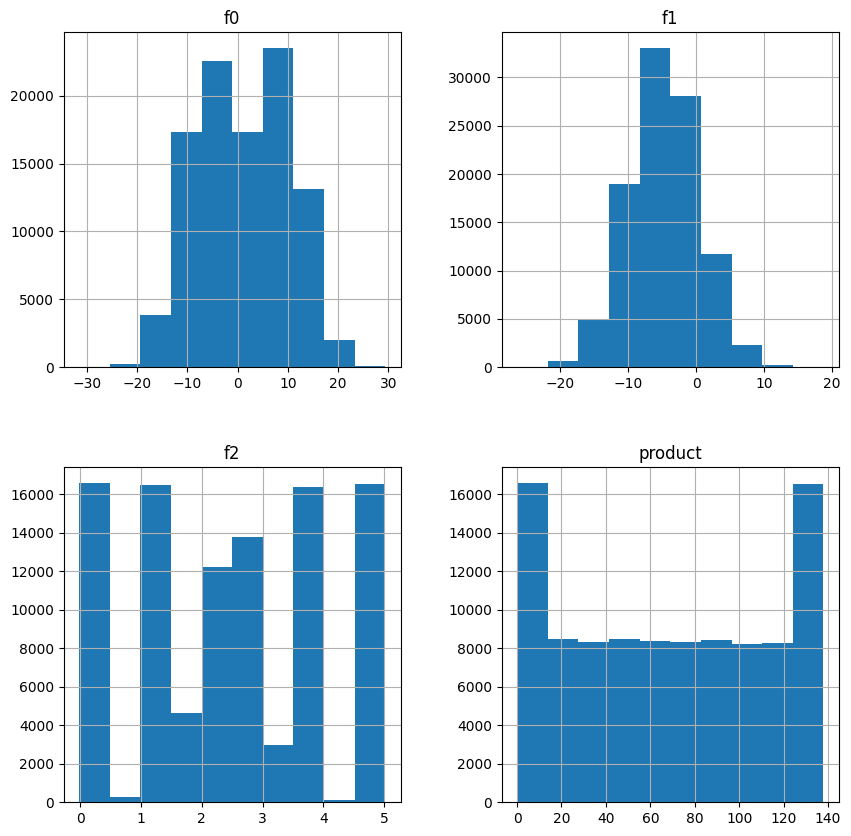

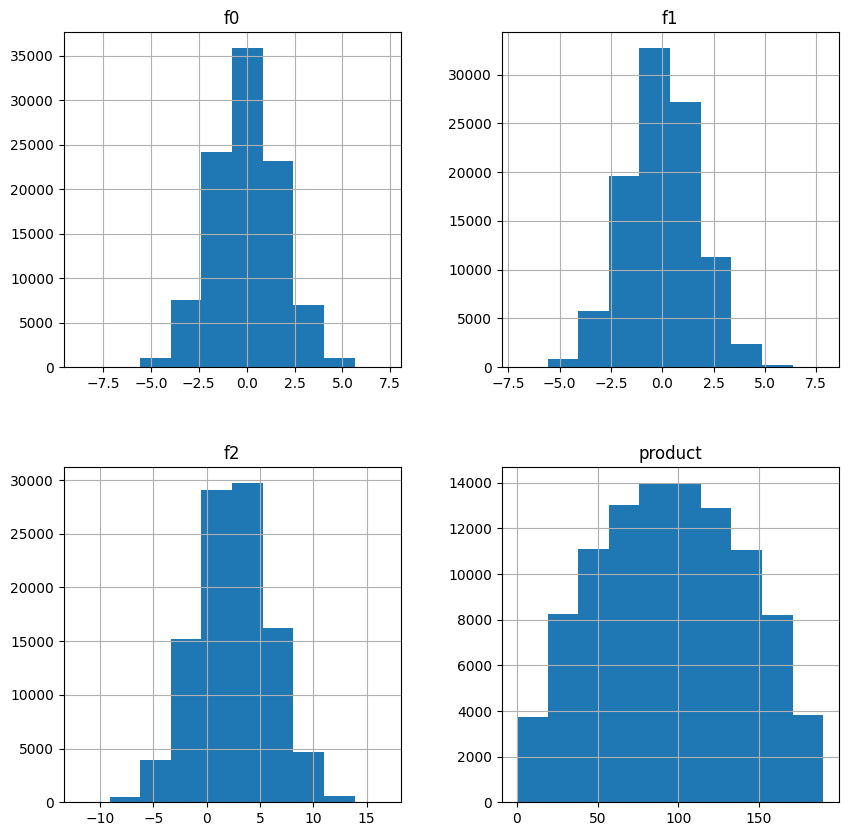

In [8]:
[globals()[f'df_{i}'].hist(figsize=(10,10)) for i in range(3)];

### Вывод
* Загружены 3 файла с данными о скважиных в разных локациях, в каждом файле 100 000 записей с информацией: id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек; product — объём запасов в скважине (тыс. баррелей).
* Выведены первые строки, информация о таблицах, статистика по значениям 
* Названия столбцов не требуют перименования
* Явные дубликаты отсутствуют
* Типы данных корректные
* Пропуски в данных отстутствуют
* Выбросы отсутствуют

Также при анализе гистограмм выявлено, что распределения product — объём запасов в скважине и оценок для первого(df_0) и третьего(2) региона близки к нормальному. Для второго(1) объём и оценка f2 не нормальны,  распределение объема ближе к равномерному, но с выбросами по краям.



## Шаг 2. Обучение и проверка модели для каждого региона

План

2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучить модель и сделайть предсказания на валидационной выборке.

2.3. Сохранить предсказания и правильные ответы на валидационной выборке.

2.4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.

2.5. Анализ результатов.



In [9]:
# разделение признаков
state = np.random.RandomState(12345) # чтобы в разных регионах были разные разделения

for i in range(3):
    globals()[f'features_{i}'] =  globals()[f'df_{i}'].drop(['product','id'] , axis=1)
    globals()[f'target_{i}'] =  globals()[f'df_{i}']['product']
    (globals()[f'features_train_{i}'], globals()[f'features_valid_{i}'],
    globals()[f'target_train_{i}'], globals()[f'target_valid_{i}']) = train_test_split(
      globals()[f'features_{i}'], globals()[f'target_{i}'], test_size=0.25, random_state=state)
    print(globals()[f'features_train_{i}'].shape, globals()[f'features_valid_{i}'].shape,
        globals()[f'target_train_{i}'].shape, globals()[f'target_valid_{i}'].shape)



(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


In [10]:
#Объединение
#features_train = pd.concat([features_train_0,features_train_1,features_train_2]
features_train = pd.concat([features_train_0,features_train_1,features_train_2], keys=['df_0','df_1','df_2'])#, ignore_index=True)
features_valid = pd.concat([features_valid_0,features_valid_1,features_valid_2], keys=['df_0','df_1','df_2'])#, ignore_index=True)
target_train = pd.concat([target_train_0,target_train_1,target_train_2], keys=['df_0','df_1','df_2'])#, ignore_index=True)
target_valid = pd.concat([target_valid_0,target_valid_1,target_valid_2], keys=['df_0','df_1','df_2'])#, ignore_index=True)

In [11]:
# масштабирование численных признаков, все признаки численные
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), index=features_train.index)
features_valid = pd.DataFrame(scaler.transform(features_valid), index=features_valid.index)

### Обучение одной общей для всех регионов модели линейной регрессии 

In [12]:
#Обучение одной общей для всех регионов модели линейной регрессии 
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = pd.Series(model.predict(features_valid), index=target_valid.index)

In [13]:
print(f'Метрики обученной модели: MSE - {mean_squared_error(target_valid, predicted_valid):.2f}, RMSE - {mean_squared_error(target_valid, predicted_valid,squared=False):.2f},',
      f'MAE - {mean_absolute_error(target_valid, predicted_valid):.2f}, R2_score - {r2_score(target_valid,predicted_valid):.3f}')
print(f'Метрики константной средней модели: MSE - {mean_squared_error(target_valid, pd.Series(target_train.mean(),target_valid.index)):.2f}, RMSE - {mean_squared_error(target_valid, pd.Series(target_train.mean(),target_valid.index),squared=False):.2f},',
      f'MAE - {mean_absolute_error(target_valid, pd.Series(target_train.mean(),target_valid.index)):.2f}, R2_score - {r2_score(target_valid, pd.Series(target_train.mean(),target_valid.index)):.3f}')
print(f"Усредненный по всем регионам запас предсказанного сырья {predicted_valid.mean():.2f}, реальный - {target_valid.mean():.2f}, RMSE модели - {mean_squared_error(target_valid, predicted_valid,squared=False):.2f}.")

Метрики обученной модели: MSE - 1496.55, RMSE - 38.69, MAE - 31.65, R2_score - 0.308
Метрики константной средней модели: MSE - 2163.92, RMSE - 46.52, MAE - 39.23, R2_score - -0.000
Усредненный по всем регионам запас предсказанного сырья 85.49, реальный - 85.20, RMSE модели - 38.69.


In [14]:
print("Метрики при обучении одной общей для всех регионов модели линейной регрессии")
for ind, num in zip(['df_0','df_1','df_2'],[' первом','о втором','о третьем']):
    print(f'В{num} регионе')
    print(f"Средний запас предсказанного сырья {predicted_valid[ind].mean():.2f}, реальный - {target_valid[ind].mean():.2f}")
    print(f"RMSE модели - {mean_squared_error(target_valid[ind], predicted_valid[ind],squared=False):.2f}",
        f'MAE - {mean_absolute_error(target_valid[ind], predicted_valid[ind]):.2f}, R2_score - {r2_score(target_valid[ind], predicted_valid[ind]):.3f}\n')


Метрики при обучении одной общей для всех регионов модели линейной регрессии
В первом регионе
Средний запас предсказанного сырья 88.45, реальный - 92.08
RMSE модели - 39.62 MAE - 32.12, R2_score - 0.199

Во втором регионе
Средний запас предсказанного сырья 79.79, реальный - 68.77
RMSE модели - 34.42 MAE - 29.18, R2_score - 0.441

Во третьем регионе
Средний запас предсказанного сырья 88.24, реальный - 94.75
RMSE модели - 41.65 MAE - 33.66, R2_score - 0.134



### Обучение отдельных моделей линейной регрессии для каждого региона

In [15]:
#Обучение отдельных моделей линейной регрессии для каждого региона
predicted_valid = pd.Series(dtype='float64')
for ind in ['df_0','df_1','df_2']:
    model = LinearRegression()
    model.fit(features_train.loc[ind], target_train[ind])
    predicted_valid[ind] = pd.Series(model.predict(features_valid.loc[ind]), index=target_valid[ind].index)

In [16]:
print("Для отдельных моделей линейной регрессии для каждого региона")
for ind, num in zip(['df_0','df_1','df_2'],[' первом','о втором','о третьем']):
    print(f'\nВ{num} регионе')
    print(f"Средний запас предсказанного сырья {predicted_valid[ind].mean():.2f},",f"реальный - {target_valid[ind].mean():.2f}")
    print(f"RMSE модели - {mean_squared_error(target_valid[ind], predicted_valid[ind],squared=False):.2f}",
        f'MAE - {mean_absolute_error(target_valid[ind], predicted_valid[ind]):.2f}, R2_score - {r2_score(target_valid[ind], predicted_valid[ind]):.4f}')
    predict_const_mean = pd.Series(target_train[ind].mean(),target_valid[ind].index)
    print(f'Метрики константной средней модели: RMSE - {mean_squared_error(target_valid[ind], predict_const_mean,squared=False):.2f},',
        f'MAE - {mean_absolute_error(target_valid[ind], predict_const_mean):.2f}')



Для отдельных моделей линейной регрессии для каждого региона

В первом регионе
Средний запас предсказанного сырья 92.59, реальный - 92.08
RMSE модели - 37.58 MAE - 30.92, R2_score - 0.2799
Метрики константной средней модели: RMSE - 44.29, MAE - 37.68

Во втором регионе
Средний запас предсказанного сырья 68.77, реальный - 68.77
RMSE модели - 0.89 MAE - 0.72, R2_score - 0.9996
Метрики константной средней модели: RMSE - 46.04, MAE - 40.38

Во третьем регионе
Средний запас предсказанного сырья 95.09, реальный - 94.75
RMSE модели - 39.96 MAE - 32.80, R2_score - 0.2026
Метрики константной средней модели: RMSE - 44.75, MAE - 37.78


### Вывод

2.1. Данные разбиты на обучающую и валидационную выборки в соотношении 3:1.

2.2. Обучена модель и сделаны предсказания на валидационной выборке.

2.3. Сохраны предсказания и правильные ответы на валидационной выборке.

2.4. Выведены на экран средний запас предсказанного сырья и RMSE модели для каждого региона и общие.

Рассмотрено два варианта построения моделей:
1. Одна общая для всех регионов
2. Три отдельных для каждого региона

В обоих вариантах построения моделей максимальный коэффициент детерминации R2 наблюдается для второго региона, т.е. модель лучше предсказывает продуктивность скважин 2 региона. Для первого и третьего регионов R2 менее 0,3, что говорит о невысоком качестве модели, но лучшем, чем у константной модели. При построении отдельных моделей для каждого региона R2 заметно возрастает по сравнению с показателем R2 общей модели и для второго региона достигает 1 (0.9996).

Одинаково для вариантов максимально предсказываемые объемы продукта наблюдаются для 1-го и 3-го регионов, реальные максимальные запасы также расположены в этих регионах (92,08 и 94,75 тыс. баррелей). Во втором регионе предсказаны и и реально содержаться минимальные средние запасы (68,77 тыс. баррелей). В третьем регионе максимальные среднеквадратическое и средне абсолютное отклонения, а минимальные - во втором регионе.

Таким образом, предпочтительнее обучать для каждого региона свою отдельную модель, так при этом улучшаются все метрики.








## Шаг 3. Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохранить в константах.

3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.

3.3. Написать выводы по этапу подготовки расчёта прибыли.

**Условия задачи:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [17]:
WELL_NUM = 500 #кол-во скажин 
BEST_WELL_NUM = 200 # кол-во отбираемых лучших скважин
BUDGET = 10e6 #тыс руб
REVENUE = 450 # тыс руб за единицу продукции
RISK = 0.025 #приемлемый риск убытков

In [18]:
# достаточный объём сырья для безубыточной разработки новой скважины
product_required_vol = BUDGET / REVENUE
print(f'Достаточный объём сырья региона для безубыточной разработки новой скважины {product_required_vol:.3f}')
print(f'Необходимый средний объём сырья одной скважины {product_required_vol / 200:.3f}')


Достаточный объём сырья региона для безубыточной разработки новой скважины 22222.222
Необходимый средний объём сырья одной скважины 111.111


### Вывод
Для для безубыточной разработки нового нефтяного региона (200 скважин) необходимый объем сырья региона должен составлять 22,(2) млн баррелей, тогда средний объем каждой скважины должен быть не меньше 111,(1) тыс баррелей, что заменто превосходит средний объем скважин валидационной выборки. 

## Шаг 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
План

4.1. Выбрать скважины с максимальными значениями предсказаний.

4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитать прибыль для полученного объёма сырья.

In [19]:
# функция расчета объема сырья и прибыли региона для лучших 200 скважин
def region_profit(predict, target):
    sampled_predict = target[predict.sort_values(ascending=False)[:BEST_WELL_NUM].index]
    sum = sampled_predict.sum()
    return (sum*REVENUE - BUDGET) /1e6 

In [20]:
# проверка функции
print('Прибыль по регионам, млрд:')
for reg_ind in ['df_0', 'df_1', 'df_2']:
    smpl_indx=predicted_valid[reg_ind].sample(WELL_NUM,random_state = state).index
    print(region_profit(
      predicted_valid[reg_ind][smpl_indx], 
      target_valid[reg_ind][smpl_indx]))

Прибыль по регионам, млрд:
0.3300163506022934
0.2144565998448748
0.09851273246287741


### Вывод
Написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели. В функции по предсказаниям выбираются из 500 скважин 200 (заданные в переменных значения) с максимальной продуктивностью, расчитывается их реальная суммарная продуктивность и прибыль в млрд. р. (за вычетом затрат на разработку скважин).

## Шаг 5. Расчет рисков и доверительного интервала прибыли для каждого региона

5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск отрицательной прибыли (убытков).

5.3. Предложить регион для разработки скважин.

ПЕРВЫЙ РЕГИОН
Средняя прибыль: 0.386 млрд.р., 95% доверительный интервал (-0.107, 0.88)
Вероятность (риск) получить убыток: 6.5 %

ВТОРОЙ РЕГИОН
Средняя прибыль: 0.448 млрд.р., 95% доверительный интервал (0.084, 0.852)
Вероятность (риск) получить убыток: 0.7 %

ТРЕТИЙ РЕГИОН
Средняя прибыль: 0.339 млрд.р., 95% доверительный интервал (-0.194, 0.865)
Вероятность (риск) получить убыток: 9.9 %

CPU times: total: 4.7 s
Wall time: 4.71 s


Text(0, 0.5, 'Средняя прибыль в регионе')

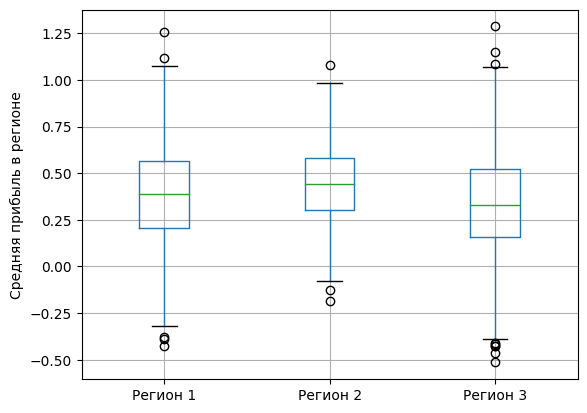

In [21]:
%%time
profit_all_reg = pd.DataFrame()
for reg_ind, region_num in zip(['df_0', 'df_1', 'df_2'],['Первый', 'Второй', 'Третий']):
    profit = []
    for j in range(1000):
        # выбор случайных 500 скважин
        smpl_indx=predicted_valid[reg_ind].sample(WELL_NUM,random_state = state).index 
        # расчет прибыли лучших 200 из 500 скважин
        profit +=[region_profit(
            predicted_valid[reg_ind][smpl_indx], 
            target_valid[reg_ind][smpl_indx])]
    profit = pd.Series(profit) 
    profit_all_reg[reg_ind] = profit
    mean = profit.mean()
    lower = profit.quantile(q=0.025)
    upper = profit.quantile(q=0.975)
    print((region_num+' регион').upper())
    print(f'Средняя прибыль: {mean:.3f} млрд.р., 95% доверительный интервал ({lower.round(3)}, {upper.round(3)})')
    print(f'Вероятность (риск) получить убыток: {percentileofscore(profit,0)} %\n')
profit_all_reg.columns = ['Регион 1','Регион 2','Регион 3']
profit_all_reg.boxplot().set_ylabel('Средняя прибыль в регионе');

### Вывод

Выполнен расчет рисков и доверительного интервала прибыли для каждого региона,использована техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков.

Как и в шаге 2 рассмотрено два варианта построения моделей.

**Результаты при построении одной общей модели:** 

|Регион| Средняя прибыль, млрд.р. |95 % доверительный интервал прибыли, млрд.р.| Риск убытка|
|--|-- |--| --|
|1| 0.202 |(-0.31, 0.676)| 21.2 %|
|2| -0.003 |(-0.394, 0.408)| 50.9 %|
|3| 0.328 |(-0.208, 0.837)| 10.8 %|

При таком построении модели регрессии ни один из регионов не подходит для разработки скважин, так как во всех регионах риск получить убыток больше 2,5%. Из рассмотреных регионов лучшие показатели наблюдаются для третьего региона - минимальный риск получить убыток: 10.8 %, и максимальная средняя прибыль - 0.328 млрд.р.

**Результаты при построении трех отдельных моделей:** 

|Регион| Средняя прибыль, млрд.р. |95 % доверительный интервал прибыли, млрд.р.| Риск убытка|
|--|-- |--| --|
|1| 0.386 |(-0.107, 0.88)| 6.5 %|
|2| 0.448 |(0.084, 0.852)| 0.7 %|
|3| 0.339 |(-0.194, 0.865)| 9.9 %|

При построении отдельных моделей для каждого региона для разработки скважин подходит только второй регион с риском убытков в 0,7%, для первого и третьего региона риски убытков 6,5% и 9,9%, т.е. больше заданного порога в 2,5%. Также во втором регионе максимальная средняя прибыль с наиболее узким доверительным интервалом. Несмотря на то, что согласно Шагу 2 во втором регионе наименьшая средняя прибыль регион оказывается единственным подходящим для разработки скважин. Это может быть объяснено тем, что продуктивность данных скважин полностью предсказуема (R2 = 1). Кроме того согласно гистограммам Шага 1 в регионе имеется две моды в области низких и высоких продуктивностей и за счет полной предсказуемости, могут быть выбраны 200 скважин с действительно высокой продуктивностью.

## Шаг 6. Общий вывод


В ходе выбора локации для новой скважины ГлавРосГосНефть было выполнено:
1. Загружены и подготовлены данные:
* Загружены 3 файла с данными о скважиных в разных локациях, в каждом файле 100 000 записей с информацией: id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек; product — объём запасов в скважине (тыс. баррелей).
* Выведены первые строки, информация о таблицах, статистику по значениям 
* Название столбцов не требуют перименования
* Явные дубликаты отсутствуют
* Типы данных корректные
* Пропуски в данных отстутствуют
* Выбросы отсутствуют

Также при анализе гистограмм выявлено, что распределения product — объём запасов в скважине и оценок для первого(df_0) и третьего(df_2) региона близки к нормальному. т.е. скаважин с максимальной продуктивностью относительно мало. Для второго (df_1) объём и оценка f2 не нормальны,  распределение объема ближе к равномерному, но с выбросами по краям, т.е. скважин с высокой продуктивностью относительно много. 

2. Обучена и проверена модель для каждого региона:
* Данные разбиты на обучающую и валидационную выборки в соотношении 3:1.
* Обучена модель и сделаны предсказания на валидационной выборке.
* Сохраны предсказания и правильные ответы на валидационной выборке.
* Выведены на экран средний запас предсказанного сырья и RMSE модели для каждого региона и общие.

Рассмотрено два варианта построения моделей:
* Одна общая для всех регионов
* Три отдельных для каждого региона

В обоих вариантах построения моделей максимальный коэффициент детерминации R2 наблюдается для второго региона, т.е. она лучше предсказывает продуктивность скважин. Для первого и третьего регионов R2 менее 0,3, что говорит о невысоком качестве модели, но лучшем, чем у константной модели. При построении отдельных моделей для каждого региона R2 заметно возрастает (по сравнению показателями R2 общей модели) и для второго региона достигает 1 (0.9996).

Одинаково для вариантов максимально предсказываемые объемы продукта наблюдаются для 1-го и 3-го регионов, реальные максимальные запасы также расположены в этих регионах (92,08 и 94,75 тыс. баррелей). Во втором регионе предсказаны и и реально содержаться минимальные средние запасы (68,77 тыс. баррелей). В третьем регионе максимальные среднеквадратическое и средне абсолютное отклонения, а минимальные - во втором регионе.

Таким образом, предпочтительнее обучать для каждого региона свою отдельную модель, так при этом улучшаются все метрики.

3. Подготовка к расчёту прибыли
* Все ключевые значения для расчётов сохранены в отдельных переменных.
* Рассчитан достаточный объём сырья для безубыточной разработки новой скважины. 
* Выполнено сравнение полученного объёма сырья со средним запасом в каждом регионе. Для безубыточной разработки нового нефтяного региона (200 скважин) необходимый объем сырья региона должен составлять 22,(2) млн. баррелей, тогда средний объем каждой скважины должен быть не меньше 111,(1) тыс. баррелей, что заменто превосходит средний объем скважин валидационной выборки.
4. Подготовлена функция для расчёта прибыли по выбранным скважинам и предсказаниям модели, которая:
* Выбирает скважины (200) с максимальными значениями предсказаний.
* Суммирует целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитывает прибыль для полученного объёма сырья.
5. Расчет рисков и доверительного интервала прибыли для каждого региона
* Применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* Найдена средняя прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

При построении отдельных моделей для каждого региона для разработки скважин подходит только второй регион с риском убытков в 0,7%, для первого и третьего региона риски убытков 6,5% и 9,9% больше заданного порога в 2,5%. Также во втором регионе максимальная средняя прибыль с наиболее узким доверительным интервалом. Несмотря на то, что согласно Шагу 2 во втором регионе наименьшая средняя прибыль регион оказывается единственным подходящим для разработки скважин. Это может быть объяснено тем, что продуктивность данных скважин полностью предсказуема (R2 = 0,9996). Кроме того, согласно гистограммам Шага 1 в регионе имеется две моды в области низких и высоких продуктивностей и за счет полной предсказуемости, могут быть выбраны 200 скважин с действительно высокой продуктивностью.

Итак, отвечая на главный вопрос проекта "где бурить новую скважину?", можно рекомендавать второй регион, при этом выбор лучших скважин должна осуществлять модель, обученная только на данных этого региона.
